# `GW_CLASS` Tutorial


This is a tutorial on how to use `GW_CLASS` with the `classy` wrapper.

We start by importing standard packages, and the `classy` python interface.

Be sure that you use the `GW_CLASS` version of `classy`
(run `make classy` or `make all` inside the `GW_CLASS` folder).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from classy import Class

## 1. Getting started: scalar and tensor contributions to $C_{\ell}^{\rm CGWB \times CGWB}$

To start of, we calculate the difference between the scalar and tensor contributions to the CGWB spectrum (compare Fig. 2 in [2305.01602](https://arxiv.org/abs/2305.01602)).

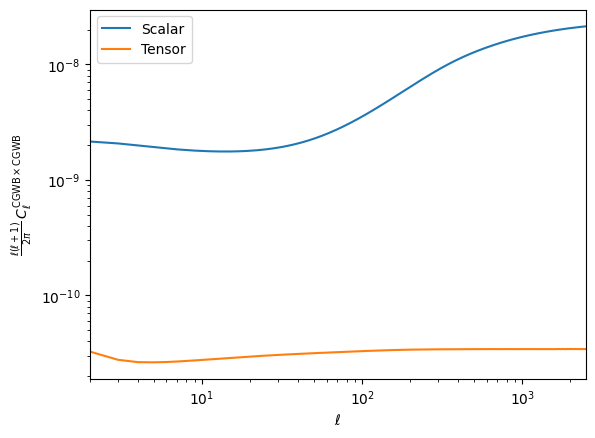

In [2]:
# We fist have to create a new instance of CLASS
M = Class()

# We now define the parameters, we want GW_CLASS to use:
l_max = 2500  # l_max for C_l^GW
settings = {
    "output": "gwCl, OmGW",  # activate C_l^GW calculation
    "modes": "s",  # only calculate scalar contribution
    "l_max_scalars": l_max,
}
M.set(settings)

# Next, we compute the C_l^GW with GW_CLASS:
M.compute()

# Now we have to extract the C_l^GW from GW_CLASS:
raw_cl = M.raw_cl(l_max)
ell = raw_cl["ell"]  # extract the array of calculated multipoles
gwcl = raw_cl["gg"]  # extract the C_l^GW (GW auto-correlation)

# We now plot the result:
gwcl *= ell * (ell + 1.0) / (2 * np.pi)  # multiply factor for visualization
plt.plot(ell, gwcl, label="Scalar")


# We now want to calculate the tensor contribution:
M.empty()  # reset the instance of CLASS
settings = {
    "output": "gwCl, OmGW",  # activate C_l^GW calculation
    "modes": "t",  # only calculate tensor contribution
    "r": 0.03,  # tensor-to-scalar ratio
    "n_t": -0.003,  # tensor spectral index
    "l_max_tensors": l_max,
}
M.set(settings)
M.compute()
raw_cl = M.raw_cl(l_max)
ell = raw_cl["ell"]
gwcl = raw_cl["gg"]
gwcl *= ell * (ell + 1.0) / (2 * np.pi)
plt.plot(ell, gwcl, label="Tensor")


# Finally, we set the plot's scale and labels:
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell (\ell+1)}{2 \pi} \, C_\ell^{\rm CGWB \times CGWB}$")
plt.xlim([2, l_max])
plt.legend()

## 2. CGWB sources

As a next step, we want to compare different sources of the CGWB. This time, we want to calculate both the anisotropies $C_{\ell}$ and the monopole/background energy density $\bar{\Omega}_{\rm GW}$ (compare Fig. 3 in [2305.01602](https://arxiv.org/abs/2305.01602)).

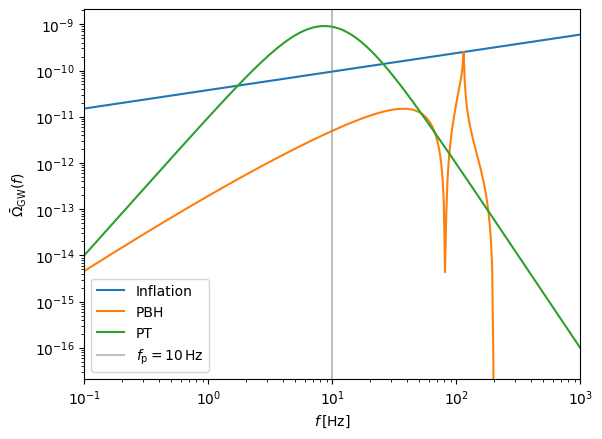

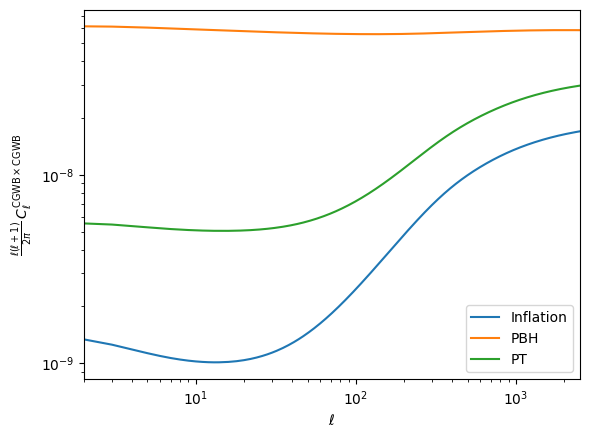

In [3]:
# We start by defining some general parameters and creating an instance of CLASS:
f_pivot = 10.0  # pivot frequency
f_min = 1e-1  # minimum frequency for Omega_GW calculation
f_max = 1000  # maximum frequency for Omega_GW calculation
l_max = 2500
M = Class()  # create an instance of CLASS

# We start by calculating the CGWB generated by infaltion:
settings = {
    "output": "gwCl, OmGW",  # activate C_l^GW and Omega_GW calculation
    "gwb_source_type": "inflationary_gwb",  # set the CGWB source to inflation
    "modes": "s, t",  # to have a CGWB generated during inlfation, we need to activate tensor modes
    "r": 0.025,  # tensor-to-scalar ratio
    "n_t": 0.4,  # we use a blue tilded CGWB spectrum
    "alpha_t": 0,  # running of the tensor spectrum
    "l_max_scalars": l_max,
    "l_max_tensors": l_max,
    "f_pivot": f_pivot,
    "f_min": f_min,
    "f_max": f_max,
    "primordial_verbose": 1,  # print information about the primordial power spectra
}
M.set(settings)
M.compute()

# Next, we extract the energy density of the CGWB:
omega_gw = M.get_omega_gw()
f = omega_gw["f [Hz]"]  # array of calculated frequency
OmGW = omega_gw["Omega_GW(f)"]  # array of calculated Omega_GW(f)

# Because we use two plots, we have to specify the figure:
plt.figure("OmGW")
plt.plot(f, OmGW, label="Inflation")

# Again, we extract the C_l^GW spectrum:
raw_cl = M.raw_cl(l_max)
ell = raw_cl["ell"]
gwcl = raw_cl["gg"]

# And plot it:
plt.figure("Cl")
gwcl *= ell * (ell + 1.0) / (2 * np.pi)
plt.plot(ell, gwcl, label="Inflation")


# Next, we calculate the CGWB generated by primordial black holes (PBHs):
M.empty()  # reset the instance of CLASS
settings = {
    "output": "gwCl, OmGW",
    "gwb_source_type": "PBH_gwb",  # set the CGWB source to PBHs
    "modes": "s",  # only calculate dominant contribution from scalar modes
    "A_star": 2e-5,  # amplitude scalar spectrum enhancement on small scales (see [2305.01602] eq. (3.5))
    "f_star": 100.0,  # enhancement scale
    "f_NL": 1,  # non-Gaussianity parameter
    "l_max_scalars": l_max,
    "f_pivot": f_pivot,
    "f_min": f_min,
    "f_max": f_max,
    "primordial_verbose": 1,
}
M.set(settings)
M.compute()
omega_gw = M.get_omega_gw()
f = omega_gw["f [Hz]"]  # array of calculated frequency
OmGW = omega_gw["Omega_GW(f)"]  # array of calculated Omega_GW(f)
plt.figure("OmGW")
plt.plot(f, OmGW, label="PBH")
raw_cl = M.raw_cl(l_max)
ell = raw_cl["ell"]
gwcl = raw_cl["gg"]
plt.figure("Cl")
gwcl *= ell * (ell + 1.0) / (2 * np.pi)
plt.plot(ell, gwcl, label="PBH")


# Third, we calculate the CGWB generated by a phase transition (PT).
# The monopole is described by a broken power-law in this case (see [2305.01602] eq. (3.18)).
# In addition to the anisotropies introduced by propagation,
# we will also consider non-adiabatic anisotropies described by a power-law (see [2305.01602] eq. (3.4)):
M.empty()  # reset the instance of CLASS
settings = {
    "output": "gwCl, OmGW",
    "gwb_source_type": "PT_gwb",  # set the CGWB source to PT
    "modes": "s",  # only calculate dominant contribution from scalar modes
    "OmegaPT_star": 1e-8,  # amplidue of the monopole
    "fPT_star": 10,  # f_*
    "nPT_1": 3,  # spectral index n_1 of the monopole
    "nPT_2": -4,  # spectral index n_2 of the monopole
    "deltaPT": 2,  # width of the transition
    "A_gwi": 1e-10,  # amplitude of the non-adiabtic GW anisotropies
    "n_gwi": 0.0,  # spectral index of the non-adiabti GW anisotropies
    "ic": "ad, gwi",  # calculate both, adiabatic and non-adiabatic anisotropies
    "l_max_scalars": l_max,
    "f_pivot": f_pivot,
    "f_min": f_min,
    "f_max": f_max,
    "primordial_verbose": 1,
}
M.set(settings)
M.compute()
omega_gw = M.get_omega_gw()
f = omega_gw["f [Hz]"]  # array of calculated frequency
OmGW = omega_gw["Omega_GW(f)"]  # array of calculated Omega_GW(f)
plt.figure("OmGW")
plt.plot(f, OmGW, label="PT")
raw_cl = M.raw_cl(l_max)
ell = raw_cl["ell"]
gwcl = raw_cl["gg"]
plt.figure("Cl")
gwcl *= ell * (ell + 1.0) / (2 * np.pi)
plt.plot(ell, gwcl, label="PT")


# Finally, we set the plot's scale and labels:
# For the Omega_GW plot:
plt.figure("OmGW")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$f \, [\mathrm{Hz}]$")
plt.ylabel(r"$\bar{\Omega}_\mathrm{GW}(f)$")
plt.xlim([f_min, f_max])
# We also want to show the pivot frequency:
plt.axvline(
    f_pivot,
    color="gray",
    alpha=0.5,
    label=r"$f_\mathrm{p}=%g \,\rm Hz$" % f_pivot,
)
plt.legend()

# And for the C_l^GW plot:
plt.figure("Cl")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell (\ell+1)}{2 \pi} \, C_\ell^{\rm CGWB \times CGWB}$")
plt.xlim([2, l_max])
plt.legend()

## 3. Adiabatic, Sach-Wolfe and Integrated Sach-Wolfe effect

The CGWB has three major contributions, from the adiabatic IC (AD),
the Sach-Wolfe (SW) effect and integrated SW (ISW) effect.
`GW_CLASS` can be used to calculate these contributions individually.
We also want to study the effect of $n_{\rm gwb}$ and $f_{\rm dec}(\eta_{\rm i})$
on the contributions (compare Fig. 1 in [2305.01602](https://arxiv.org/abs/2305.01602)).

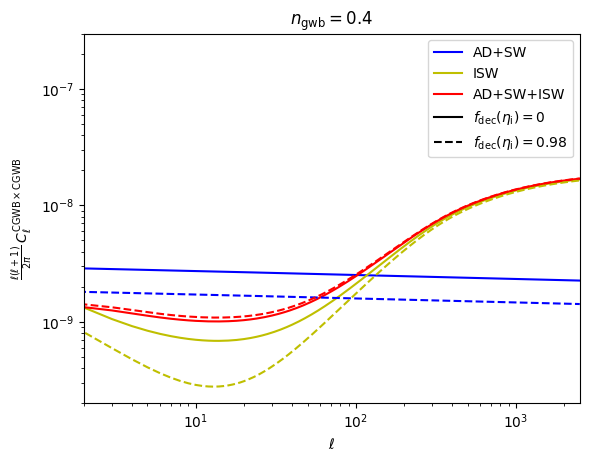

In [4]:
# We start by defining some settings that are the same for all calculations:
common_settings = {
    "output": "gwCl, OmGW",
    "gwb_source_type": "analytic_gwb",
    "Omega_gwb": 1.0e-10,  # Amplitude of the spectral CGWB energy density
    # We do the calculation for a spectral index of n_gwb = 0.4, alternatively for n_gwb = -2:
    "n_gwb": 0.4,
    # "n_gwb": -2.0,
    # Next we define the fraction of decoupled relativistic species at GW production f_dec(eta_i).
    # We start with a value of f_dec(eta_i) = 0.0:
    "f_dec_ini": 0.0,
    "l_max_scalars": 2500,
}
M = Class()  # create an instance of CLASS


# We start with the adiabitc + SW contribution:
M.set(common_settings)  # use the common settings
settings = {"gravitational_wave_contributions": "ad, tsw"}  # adiabatic IC + SW
M.set(settings)
M.compute()
raw_cl = M.raw_cl(l_max)
ell = raw_cl["ell"]
gwcl = raw_cl["gg"]
gwcl *= ell * (ell + 1.0) / (2 * np.pi)
plt.plot(ell, gwcl, "b-", label="AD+SW")

# Next, we calculate the ISW contribution:
M.empty()  # reset the instance of CLASS
M.set(common_settings)  # use the common settings
# The total ISW is a sum of the primary ISW (pisw), the early ISW (eisw) and the late ISW (lisw):
settings = {"gravitational_wave_contributions": "pisw, eisw, lisw"}
M.set(settings)
M.compute()
raw_cl = M.raw_cl(l_max)
ell = raw_cl["ell"]
gwcl = raw_cl["gg"]
gwcl *= ell * (ell + 1.0) / (2 * np.pi)
plt.plot(ell, gwcl, "y-", label="ISW")

# The total CGWB:
M.empty()
M.set(common_settings)
settings = {"gravitational_wave_contributions": "ad, tsw, pisw, eisw, lisw"}
M.set(settings)
M.compute()
raw_cl = M.raw_cl(l_max)
ell = raw_cl["ell"]
gwcl = raw_cl["gg"]
gwcl *= ell * (ell + 1.0) / (2 * np.pi)
plt.plot(ell, gwcl, "r-", label="AD+SW+ISW")


# We now do the same again, but with f_dec(eta_i) = 0.98:
common_settings[
    "f_dec_ini"
] = 0.98  # set f_dec(eta_i) = 0.98 for all following calculations

# Adiabatic + SW:
M.set(common_settings)  # use the common settings, now with f_dec(eta_i) = 0.98
settings = {"gravitational_wave_contributions": "ad, tsw"}  # adiabatic IC + SW
M.set(settings)
M.compute()
raw_cl = M.raw_cl(l_max)
ell = raw_cl["ell"]
gwcl = raw_cl["gg"]
gwcl *= ell * (ell + 1.0) / (2 * np.pi)
plt.plot(ell, gwcl, "b--")  # use dashed lines for f_dec(eta_i) = 0.98

# ISW:
M.empty()
M.set(common_settings)
settings = {"gravitational_wave_contributions": "pisw, eisw, lisw"}  # ISW
M.set(settings)
M.compute()
raw_cl = M.raw_cl(l_max)
ell = raw_cl["ell"]
gwcl = raw_cl["gg"]
gwcl *= ell * (ell + 1.0) / (2 * np.pi)
plt.plot(ell, gwcl, "y--")

# The total CGWB:
M.empty()
M.set(common_settings)
settings = {"gravitational_wave_contributions": "ad, tsw, pisw, eisw, lisw"}
M.set(settings)
M.compute()
raw_cl = M.raw_cl(l_max)
ell = raw_cl["ell"]
gwcl = raw_cl["gg"]
gwcl *= ell * (ell + 1.0) / (2 * np.pi)
plt.plot(ell, gwcl, "r--")


# Finally, we set the plot's scale and labels:
plt.title(r"$n_{\rm gwb} = %.1f$" % common_settings["n_gwb"])  # set the title
plt.plot(
    [], [], "k-", label=r"$f_\mathrm{dec}(\eta_\mathrm{i}) = 0$"
)  # add legend for f_dec(eta_i) = 0
plt.plot(
    [], [], "k--", label=r"$f_\mathrm{dec}(\eta_\mathrm{i}) = 0.98$"
)  # add legend for f_dec(eta_i) = 0.98
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell (\ell+1)}{2 \pi} \, C_\ell^{\rm CGWB \times CGWB}$")
plt.xlim([2, l_max])
plt.ylim([2e-10, 3e-7])
plt.legend()

## 4. Cross-correlation between CMB and CGWB

`GW_CLASS` allows to calculate both the CMB and the CGWB as well as the
cross-correlation between them (compare Fig. 6 in [2305.01602](https://arxiv.org/abs/2305.01602)).

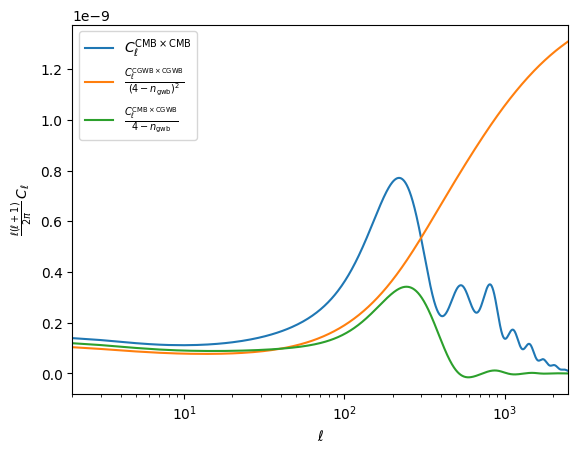

In [5]:
# We start by defining the parameters for GW_CLASS
l_max = 2500
settings = {
    # We have to calculate both the CMB (tCL) and the CGWB (gwCl, OmGW):
    "output": "tCl, gwCl, OmGW",
    # To have a better comparison with the CMB, we calculate the pertrubation of
    # the  distribution function instead of the energy density:
    "convert_gwb_to_energydensity": "no",
    "n_gwb": 0.4,
    # We want to have the following contributions to CGWB and CMB:
    "gravitational_wave_contributions": "ad, tsw, pisw, eisw, lisw",  # AD+SW+ISW
    "temperature_contributions": "tsw, eisw, lisw, dop",  # SW+ISW+Doppler
    "l_max_scalars": l_max,
}


# Next, we compute the C_l with GW_CLASS:
M = Class()
M.set(settings)
M.compute()


# Now we have to extract the C_l from GW_CLASS:
raw_cl = M.raw_cl(l_max)
ell = raw_cl["ell"]  # extract the array of calculated multipoles
factor = ell * (ell + 1.0) / (2 * np.pi)  # factor for visualization

# We first extract and plot the CMB angular power spectrum:
tcl = raw_cl["tt"]  #  C_l^CMBxCMB (CMB auto-correlation)
plt.plot(ell, factor * tcl, label=r"$C_\ell^{\rm CMB \times CMB}$")

# Next, we extract and plot the CGWB angular power spectrum:
gwcl = raw_cl["gg"]  #  C_l^CGWBxCGWB (CGWB auto-correlation)
plt.plot(
    ell,
    factor * gwcl,
    label=r"$\frac{C_\ell^{\rm CGWB \times CGWB}}{(4 - n_{\rm gwb})^2}$",
)

# Last, we extract and plot the cross-correlation between CMB and CGWB:
tgwcl = raw_cl["tg"]  #  C_l^CMBxCGWB (cross-correlation)
plt.plot(
    ell,
    factor * tgwcl,
    label=r"$\frac{C_\ell^{\rm CMB \times CGWB}}{4 - n_{\rm gwb}}$",
)


# Finally, we set the plot's scale and labels:
plt.xscale("log")
plt.yscale("linear")  # linear y-axis, because cross-correlation can be negative
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell (\ell+1)}{2 \pi} \, C_\ell$")
plt.xlim([2, l_max])
plt.legend()

## 5. Frequency correlations

The CGWB anisotropies at different frequencies $f$ are correlated.
`GW_CLASS` allows for efficient and easy calculations of these cross-correlations.
Here, we introduce the interface to efficiently calculate
$C_{\ell}^{\rm CGWB \times CGWB}(f_1, f_2)$
for many frequencies $f_1$, $f_2$ at once.

We present the results in a 2D plot of the correlation factor
$$
    r_\ell(f_1,f_2) \equiv \frac{C_\ell^{\rm CGWB \times CGWB}(f_1,f_2)}{\sqrt{C_\ell^{\rm CGWB \times CGWB}(f_1,f_1) C_\ell^{\rm CGWB \times CGWB}(f_2,f_2)}} \, .
$$

As example, we use a CGWB created by PBHs (compare Fig. 4 in [2305.01602](https://arxiv.org/abs/2305.01602)).

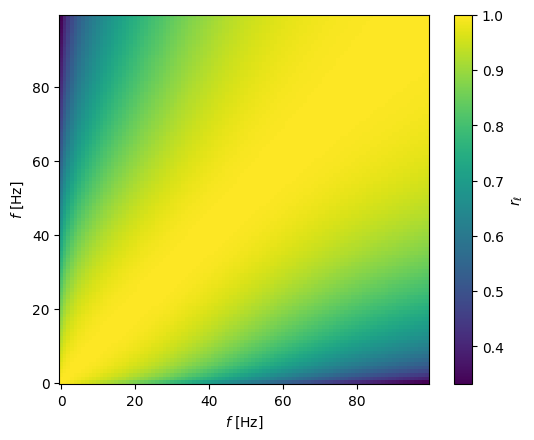

In [7]:
# Again, we start by setting the general parameters
settings = {
    "output": "gwCl, OmGW",
    "gwb_source_type": "PBH_gwb",  # use CGWB created by PBHs
    "A_star": 2e-5,
    "f_star": 100.0,
    "f_NL": 1e-2,
    "f_dec_ini": 0.0,
}


# Next, we create an array of frequencies at which we want to calculate the GW spectrum:
f_gwb = np.linspace(1, 60, 100)  # frequencies = [1 - 60] Hz
# In order to pass the array to CLASS, we need to convert it to a string separated by commas:
str_f_gwb = ", ".join("%.2e" % x for x in f_gwb)
settings["f_gwb"] = str_f_gwb
# We also have to set the frequency range at which the monopole Omega_GW is calculated.
# This is completely independent of the frequency range at which the GW spectrum is calculated,
# but since the monopole is used to normalize the GW spectrum.
# Therefore, we need to make sure that the frequency range is wide enough:
settings["f_min"] = min(f_gwb) * 0.8  # min frequency a bit lower than f_gwb
settings["f_max"] = max(f_gwb) * 1.2  # max frequency a bit higher than f_gwb
settings["f_pivot"] = f_gwb[0]  # f_pivot must be between f_min and f_max


# Now we define, for which multipoles l we want to calculate r_l(f_1, f_2):
ell = 2
# GW_CLASS calculates r_l for all multipoles up to l_max.
# To ensure accurate results, we set l_max to be a bit larger than ell:
settings["l_max_scalars"] = ell + 20


# We can now create an instance of CLASS and compute the GW spectrum:
M = Class()
M.set(settings)
M.compute()


# Now we can extract the C_l^{gg}(f_1, f_2). 
# This time we have to use a different method, to extract the frequency dependent C_l^CGWBxCGWB(f_1, f_2):
cl = M.cgwb_cl()
# We first get the exact frequencies used by GW_CLASS.
# These equal f_gwb up to numerical/input precision:
freqs = cl["f_gwb [Hz]"]
# Next, we get the array of multipoles l calculated by GW_CLASS, and find the index of ell:
ells = cl["ell"]
index_ell = np.where(ells == ell)[0][0]  # for small ell: index_ell == ell
# Last, we get the C_l^CGWBxCGWB(f_1, f_2).
# This is an 3D array with the structure gwcls[f_1, f_2, ell]:
gwcls = cl["gg"]
gwcl = gwcls[:, :, index_ell]  # extract 2D array for ell=2


# The next step is to calculate r_ell(f_1, f_2):
gwcl_auto = np.diag(gwcl)  # auto-correlation of C_l^CGWBxCGWB(f_1, f_1)
rell = gwcl / np.sqrt(np.outer(gwcl_auto, gwcl_auto))


# Finally, we can plot the result:
fig, ax = plt.subplots()
im = ax.imshow(rell)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(r"$r_\ell$", rotation=90)
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$f$ [Hz]")
ax.invert_yaxis()  # invert y-axis to have (0,0) in the lower left corner

Another possibility to show the frequency correlation is to plot
$$
    \frac{C_\ell^{\rm CGWB \times CGWB}(f_{\rm p}, f)}{C_\ell^{\rm CGWB \times CGWB}(f_{\rm p}, f_{\rm p})} \, .
$$
(Compare Fig. 5 in [2305.01602](https://arxiv.org/abs/2305.01602).)

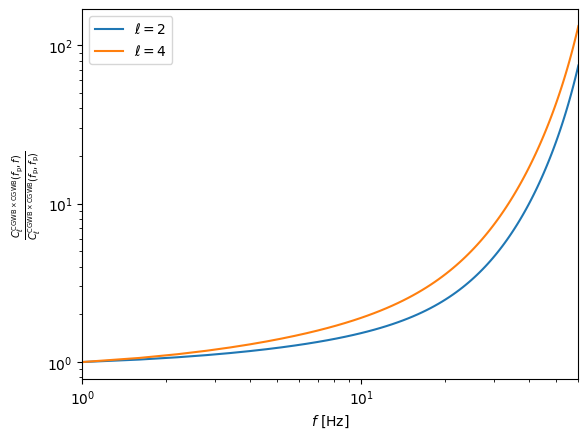

In [8]:
# We can reuse the instance of Class from above:
fig = plt.figure()

# We extract x = C_l(f_p, f) / C_l(f_p, f_p) for l = 2, using f_p = f_gwb[0]:
l = 2
x = np.diag(gwcls[:, :, l]) / gwcls[0, 0, l]
# And plot x(f) vs. f:
plt.plot(freqs, x, label=r"$\ell = %i$" % ells[l])

# We also plot l = 4:
l = 4
x = np.diag(gwcls[:, :, l]) / gwcls[0, 0, l]
plt.plot(freqs, x, label=r"$\ell = %i$" % ells[l])

# Last, we set the lables:
plt.xlabel(r"$f$ [Hz]")
plt.xlim([min(freqs), max(freqs)])
plt.ylabel(
    r"$\frac{C_\ell^{\rm CGWB \times CGWB}(f_{\rm p}, f)}"
    r"{C_\ell^{\rm CGWB \times CGWB}(f_{\rm p}, f_{\rm p})}$"
)
plt.xscale("log")
plt.yscale("log")
plt.legend()

## 6. Contributions to $\rm CMB \times CGWB$ cross-correlations

As a last example, we reproduce Fig. 7 in [2305.01602](https://arxiv.org/abs/2305.01602).
It shows the cross-correlations between the different contributions to the 
CMB (SW, ISW, Doppler) and the CGWB (SW, ISW)
(here the SW effect in the CGWB includes the adiabatic IC).
This tutorial is similar to tutorial 4: Cross-correlation between CMB and CGWB.
A difference is, that here we include the factor of $4 - n_{\rm gwb}$ for the CGWB
to convert to the energy density fluctuations.

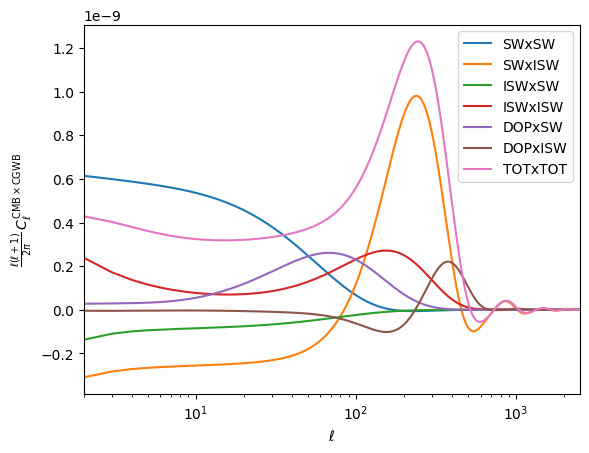

In [9]:
# Start by defining the parameters for GW_CLASS
l_max = 2500
settings = {
    # Calculate both CMB and CGWB to get the cross-correlation:
    "output": "tCl, gwCl, OmGW",
    "convert_gwb_to_energydensity": "yes",  # include 4 - n_gwb factor
    "n_gwb": 0.4,
    "f_dec_ini": 0.0,
    "l_max_scalars": l_max,
}
M = Class()


# SWxSW cross-correlation:
settings["temperature_contributions"] = "tsw"  # SW
settings["gravitational_wave_contributions"] = "ad, tsw"  # AD+SW
M.set(settings)
M.compute()
raw_cl = M.raw_cl(l_max)
ell = raw_cl["ell"]  # extract the array of calculated multipoles
factor = ell * (ell + 1.0) / (2 * np.pi)  # factor for visualization
tgwcl = raw_cl["tg"]  # extract the cross-correlation C_l^CMBxCGWB
plt.plot(ell, factor * tgwcl, label="SWxSW")

# SWxISW cross-correlation:
settings["temperature_contributions"] = "tsw"  # SW
settings["gravitational_wave_contributions"] = "pisw, eisw, lisw"  # ISW
M.empty()  # reset the class instance
M.set(settings)
M.compute()
raw_cl = M.raw_cl(l_max)
tgwcl = raw_cl["tg"]
plt.plot(ell, factor * tgwcl, label="SWxISW")  # ell does not change

# ISWxSW cross-correlation:
settings["temperature_contributions"] = "eisw, lisw"  # ISW
settings["gravitational_wave_contributions"] = "ad, tsw"  # SW
M.empty()
M.set(settings)
M.compute()
plt.plot(ell, factor * M.raw_cl(l_max)["tg"], label="ISWxSW")  # combine lines

# ISWxISW cross-correlation:
settings["temperature_contributions"] = "eisw, lisw"  # ISW
settings["gravitational_wave_contributions"] = "pisw, eisw, lisw"  # ISW
M.empty()
M.set(settings)
M.compute()
plt.plot(ell, factor * M.raw_cl(l_max)["tg"], label="ISWxISW")

# DOPxSW cross-correlation:
settings["temperature_contributions"] = "dop"  # Doppler
settings["gravitational_wave_contributions"] = "ad, tsw"  # SW
M.empty()
M.set(settings)
M.compute()
plt.plot(ell, factor * M.raw_cl(l_max)["tg"], label="DOPxSW")

# DOPxISW cross-correlation:
settings["temperature_contributions"] = "dop"  # Doppler
settings["gravitational_wave_contributions"] = "pisw, eisw, lisw"  # ISW
M.empty()
M.set(settings)
M.compute()
plt.plot(ell, factor * M.raw_cl(l_max)["tg"], label="DOPxISW")

# Totoal cross-correlation spectrum:
settings["temperature_contributions"] = "tsw, eisw, lisw, dop"
settings["gravitational_wave_contributions"] = "tsw, ad, pisw, eisw, lisw"
M.empty()
M.set(settings)
M.compute()
plt.plot(ell, factor * M.raw_cl(l_max)["tg"], label="TOTxTOT")


# Set the plot scale and labels:
plt.xscale("log")
plt.yscale("linear")  # linear y-axis, because cross-correlation can be negative
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell (\ell+1)}{2 \pi} \, C_\ell^{\rm CMB \times CGWB}$")
plt.xlim([2, l_max])
plt.legend()